In [536]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.special import lpmn
import pandas as pd
from datetime import datetime
import sympy as sym
import csv

In [537]:
#Rotation Martices
def R1(theta):
    return np.array([[1, 0, 0], \
                     [0, np.cos(theta), np.sin(theta)], \
                     [0, -np.sin(theta), np.cos(theta)]])
def R2(theta):
    return np.array([[np.cos(theta), 0, -np.sin(theta)],\
                    [0, 1, 0], \
                    [np.sin(theta), 0, np.cos(theta)]])
def R3(theta):
    return np.array([[np.cos(theta), np.sin(theta), 0], \
                     [-np.sin(theta), np.cos(theta), 0], \
                    [0, 0, 1]])

In [834]:
def read_nut80():
    # IAU1980 Theory of Nutation model
    dat_file = "nut80.dat"  

    #nutaton model column names
    column_names = ['ki1', 'ki2', 'ki3', 'ki4', 'ki5', 'Aj', 'Bj', 'Cj', 'Dj', 'j']

    #nutation dataframe
    df = pd.read_csv(dat_file, sep="\s+", names=column_names)
    return df

df = read_nut80()

In [698]:
def gregorian_to_jd(year, month, day, hour, minute, second):
    a = int((14 - month)/12)
    y = year + 4800 - a
    m = month + 12*a - 3
    jd = day + int((153*m + 2)/5) + 365*y + int(y/4) - int(y/100) + int(y/400) - 32045
    jd = jd + (hour - 12)/24 + minute/1440 + second/86400
    return jd

In [838]:
def ECI2ECEF(r_ECI, JD_UTC, x_p, y_p, leap_sec, del_UT1):

    '''
    Converts ECI to ECEF using IAU-76/FK5

    Inputs:
    r_ECI: ECI position vector in km
    JD_UTC: Julian Date in UTC
    x_p: x polar motion in arc seconds
    y_p: y polar motion in arc seconds
    leap_sec: leap seconds
    del_UT1: UT1-UTC in seconds

    returns: ECI position vector in km
    '''

    # time constants
    JD2000 = 2451545.0

    #T_UT1
    JD_UT1 = JD_UTC + del_UT1/86400
    T_UT1 = (JD_UT1-JD2000)/36525

    #T_TT
    TAI = JD_UTC + leap_sec/86400
    JD_TT = TAI + 32.184/86400
    T_TT = (JD_TT-JD2000)/36525

    #radians conversions
    arc_sec_to_rad = np.pi/(180*3600)
    deg2rad = np.pi/180

    #Earth Rotation Angles
    x_p = x_p*arc_sec_to_rad
    y_p = x_p*arc_sec_to_rad

    # Polar Motion Matrix
    W = np.matmul(R1(y_p), R2(x_p))
    # r_PEF = np.matmul(W, r_ECEF)

    #Greenwich Mean Sidereal Time
    GMST = 67310.54841 + (876600*3600 + 8640184.812866)*T_UT1 + 0.093104*T_UT1**2 - 6.2E-6*T_UT1**3

    #convert GMST to radians
    GMST = GMST/240*deg2rad

    #anamolies
    r = 360
    Mmoon = (134.96298139 + (1325*r + 198.8673981)*T_TT + 0.0086972*T_TT**2 + 1.78E-5*T_TT**3)
    Mdot = (357.52772333 + (99*r + 359.0503400)*T_TT - 0.0001603*T_TT**2 - 3.3E-6*T_TT**3)
    uMoon = (93.27191028 + (1342*r + 82.0175381)*T_TT - 0.0036825*T_TT**2 + 3.1E-6*T_TT**3)
    Ddot = (297.85036306 + (1236*r + 307.1114800)*T_TT - 0.0019142*T_TT**2 + 5.3E-6*T_TT**3)
    lamMoon = (125.04452222 - (5*r + 134.1362608)*T_TT + 0.0020708*T_TT**2 + 2.2E-6*T_TT**3)
    alpha = np.array([Mmoon, Mdot, uMoon, Ddot, lamMoon])*deg2rad

    # # IAU1980 Theory of Nutation model
    # dat_file = "nut80.dat"  

    # #nutaton model column names
    # column_names = ['ki1', 'ki2', 'ki3', 'ki4', 'ki5', 'Aj', 'Bj', 'Cj', 'Dj', 'j']

    # #nutation dataframe
    # df = pd.read_csv(dat_file, sep="\s+", names=column_names)

    #nutation in lam
    del_psi = np.dot((df['Aj']*10**-4 + df['Bj']*10**-4*T_TT)*arc_sec_to_rad, np.sin(np.dot(df[df.columns[0:5]], alpha)))

    #nutation in obliquity
    del_epsilon = np.dot((df['Cj']*10**-4 + df['Dj']*10**-4*T_TT)*arc_sec_to_rad, np.cos(np.dot(df[df.columns[0:5]], alpha)))

    #mean obliquity of the ecliptic
    epsilon_m = 84381.448 - 46.8150*T_TT - 0.00059*T_TT**2 + 0.001813*T_TT**3

    #EOP corrections
    # ddel_psi = -104.524E-3
    # ddel_epsilon = -8.685E-3

    #conversion to radians
    epsilon_m = epsilon_m*arc_sec_to_rad

    #true obliquity of the ecliptic
    epsilon = epsilon_m + del_epsilon

    #equation of the equinoxes
    Eq_eq = del_psi*np.cos(epsilon_m) + 0.000063*arc_sec_to_rad*np.sin(2*alpha[4]) + 0.00264*arc_sec_to_rad*np.sin(alpha[4])

    #greenwich apparent sidereal time
    GAST = GMST + Eq_eq

    #sidereal rotation matrix
    R = R3(-GAST)
    # r_TOD = np.matmul(R, r_PEF)

    #nutation matrix R1, R3, R1
    N = np.matmul(np.matmul(R1(-epsilon_m), R3(del_psi)), R1(epsilon))
    # r_mod = np.matmul(N, r_TOD)

    #precession angles
    C_a = (2306.2181*T_TT + 0.30188*T_TT**2 + 0.017998*T_TT**3)*arc_sec_to_rad
    theta_a = (2004.3109*T_TT - 0.42665*T_TT**2 - 0.041833*T_TT**3)*arc_sec_to_rad
    z_a = (2306.2181*T_TT + 1.09468*T_TT**2 + 0.018203*T_TT**3)*arc_sec_to_rad

    #precession matrix
    P = np.matmul(np.matmul(R3(C_a), R2(-theta_a)), R3(z_a))

    r_ECEF = np.matmul(np.matmul(np.matmul(np.matmul(W.T, R.T), N.T), P.T), r_ECI)
    return r_ECEF


In [981]:
def ECEF2ECI(r_ECEF, JD_UTC, x_p, y_p, leap_sec, del_UT1):

    '''
    Converts ECEF to ECI using IAU-76/FK5

    Inputs:
    r_ECEF: ECEF position vector in km
    JD_UTC: Julian Date in UTC
    x_p: x polar motion in arc seconds
    y_p: y polar motion in arc seconds
    leap_sec: leap seconds
    del_UT1: UT1-UTC in seconds

    returns: ECI position vector in km
    '''

    # time constants
    JD2000 = 2451545.0

    #T_UT1
    JD_UT1 = JD_UTC + del_UT1/86400
    T_UT1 = (JD_UT1-JD2000)/36525

    #T_UT1
    TAI = JD_UTC + leap_sec/86400
    JD_TT = TAI + 32.184/86400
    T_TT = (JD_TT-JD2000)/36525

    #radians conversions
    arc_sec_to_rad = np.pi/(180*3600)
    deg2rad = np.pi/180

    #Earth Rotation Angles
    x_p = x_p*arc_sec_to_rad
    y_p = x_p*arc_sec_to_rad

    # Polar Motion Matrix
    W = np.matmul(R1(y_p), R2(x_p))
    # r_PEF = np.matmul(W, r_ECEF)

    #Greenwich Mean Sidereal Time
    GMST = 67310.54841 + (876600*3600 + 8640184.812866)*T_UT1 + 0.093104*T_UT1**2 - 6.2E-6*T_UT1**3

    #convert GMST to radians
    GMST = GMST/240*deg2rad

    #anamolies
    r = 360
    Mmoon = (134.96298139 + (1325*r + 198.8673981)*T_TT + 0.0086972*T_TT**2 + 1.78E-5*T_TT**3)
    Mdot = (357.52772333 + (99*r + 359.0503400)*T_TT - 0.0001603*T_TT**2 - 3.3E-6*T_TT**3)
    uMoon = (93.27191028 + (1342*r + 82.0175381)*T_TT - 0.0036825*T_TT**2 + 3.1E-6*T_TT**3)
    Ddot = (297.85036306 + (1236*r + 307.1114800)*T_TT - 0.0019142*T_TT**2 + 5.3E-6*T_TT**3)
    lamMoon = (125.04452222 - (5*r + 134.1362608)*T_TT + 0.0020708*T_TT**2 + 2.2E-6*T_TT**3)
    alpha = np.array([Mmoon, Mdot, uMoon, Ddot, lamMoon])*deg2rad

    # # IAU1980 Theory of Nutation model
    # dat_file = "nut80.dat"  

    # #nutaton model column names
    # column_names = ['ki1', 'ki2', 'ki3', 'ki4', 'ki5', 'Aj', 'Bj', 'Cj', 'Dj', 'j']

    # #nutation dataframe
    # df = pd.read_csv(dat_file, sep="\s+", names=column_names)

    #nutation in lam
    del_psi = np.dot((df['Aj']*10**-4 + df['Bj']*10**-4*T_TT)*arc_sec_to_rad, np.sin(np.dot(df[df.columns[0:5]], alpha)))

    #nutation in obliquity
    del_epsilon = np.dot((df['Cj']*10**-4 + df['Dj']*10**-4*T_TT)*arc_sec_to_rad, np.cos(np.dot(df[df.columns[0:5]], alpha)))

    #mean obliquity of the ecliptic
    epsilon_m = 84381.448 - 46.8150*T_TT - 0.00059*T_TT**2 + 0.001813*T_TT**3

    #EOP corrections
    # ddel_psi = -104.524E-3
    # ddel_epsilon = -8.685E-3

    #conversion to radians
    epsilon_m = epsilon_m*arc_sec_to_rad

    #true obliquity of the ecliptic
    epsilon = epsilon_m + del_epsilon

    #equation of the equinoxes
    Eq_eq = del_psi*np.cos(epsilon_m) + 0.000063*arc_sec_to_rad*np.sin(2*alpha[4]) + 0.00264*arc_sec_to_rad*np.sin(alpha[4])

    #greenwich apparent sidereal time
    GAST = GMST + Eq_eq

    #sidereal rotation matrix
    R = R3(-GAST)
    # r_TOD = np.matmul(R, r_PEF)

    #nutation matrix R1, R3, R1
    N = np.matmul(np.matmul(R1(-epsilon_m), R3(del_psi)), R1(epsilon))
    # r_mod = np.matmul(N, r_TOD)

    #precession angles
    C_a = (2306.2181*T_TT + 0.30188*T_TT**2 + 0.017998*T_TT**3)*arc_sec_to_rad
    theta_a = (2004.3109*T_TT - 0.42665*T_TT**2 - 0.041833*T_TT**3)*arc_sec_to_rad
    z_a = (2306.2181*T_TT + 1.09468*T_TT**2 + 0.018203*T_TT**3)*arc_sec_to_rad

    #precession matrix
    P = np.matmul(np.matmul(R3(C_a), R2(-theta_a)), R3(z_a))

    r_ECI = np.matmul(np.matmul(np.matmul(np.matmul(P, N), R), W), r_ECEF)
    return r_ECI




In [924]:
def sun_position_vector(JD_UTC, del_UT1, leap_sec):
    
    # Constants
    deg2rad = np.pi / 180.0
    au = 149597870.691*1000 # Astronomical unit [m]
    arc_sec_to_rad = np.pi/(180*3600)
    # Time variables
    
    JD2000 = 2451545.0

    #T_UT1
    JD_UT1 = JD_UTC + del_UT1/86400
    T_UT1 = (JD_UT1-JD2000)/36525

    #T_TT
    TAI = JD_UTC + leap_sec/86400
    JD_TT = TAI + 32.184/86400
    T_TT = (JD_TT-JD2000)/36525

    # Mean lam of the Sun
    l = (280.460 + 36000.771285 * T_UT1) %360

    # Mean anomaly of the Sun
    M = (357.528 + 35999.050957 * T_UT1) %360

    # Ecliptic lam of the Sun
    lambda_sun = l + 1.915 * np.sin(M * deg2rad) + 0.020 * np.sin(2 * M * deg2rad)

    # Obliquity of the ecliptic
    epsilon = 23.439291 - 0.01461 * T_UT1

    #magnitude of the sun
    R = 1.00014 - 0.01671 * np.cos(M * deg2rad) - 0.00014 * np.cos(2 * M * deg2rad)

    #sun position vector in ecliptic coordinates
    r_ecliptic = np.array([R * np.cos(lambda_sun * deg2rad), 
                           R * np.cos(epsilon * deg2rad) * np.sin(lambda_sun * deg2rad), 
                           R * np.sin(epsilon * deg2rad) * np.sin(lambda_sun * deg2rad)])
    
    #rotation from TOD to ECI

    #anamolies
    r = 360
    Mmoon = (134.96298139 + (1325*r + 198.8673981)*T_TT + 0.0086972*T_TT**2 + 1.78E-5*T_TT**3)
    Mdot = (357.52772333 + (99*r + 359.0503400)*T_TT - 0.0001603*T_TT**2 - 3.3E-6*T_TT**3)
    uMoon = (93.27191028 + (1342*r + 82.0175381)*T_TT - 0.0036825*T_TT**2 + 3.1E-6*T_TT**3)
    Ddot = (297.85036306 + (1236*r + 307.1114800)*T_TT - 0.0019142*T_TT**2 + 5.3E-6*T_TT**3)
    lamMoon = (125.04452222 - (5*r + 134.1362608)*T_TT + 0.0020708*T_TT**2 + 2.2E-6*T_TT**3)
    alpha = np.array([Mmoon, Mdot, uMoon, Ddot, lamMoon])*deg2rad


    #nutation in lam
    del_psi = np.dot((df['Aj']*10**-4 + df['Bj']*10**-4*T_TT)*arc_sec_to_rad, np.sin(np.dot(df[df.columns[0:5]], alpha)))

    #nutation in obliquity
    del_epsilon = np.dot((df['Cj']*10**-4 + df['Dj']*10**-4*T_TT)*arc_sec_to_rad, np.cos(np.dot(df[df.columns[0:5]], alpha)))

    #mean obliquity of the ecliptic
    epsilon_m = 84381.448 - 46.8150*T_TT - 0.00059*T_TT**2 + 0.001813*T_TT**3

    #conversion to radians
    epsilon_m = epsilon_m*arc_sec_to_rad

    #true obliquity of the ecliptic
    epsilon = epsilon_m + del_epsilon

    #nutation matrix R1, R3, R1
    N = np.matmul(np.matmul(R1(-epsilon_m), R3(del_psi)), R1(epsilon))

    #precession angles
    C_a = (2306.2181*T_TT + 0.30188*T_TT**2 + 0.017998*T_TT**3)*arc_sec_to_rad
    theta_a = (2004.3109*T_TT - 0.42665*T_TT**2 - 0.041833*T_TT**3)*arc_sec_to_rad
    z_a = (2306.2181*T_TT + 1.09468*T_TT**2 + 0.018203*T_TT**3)*arc_sec_to_rad

    #precession matrix
    P = np.matmul(np.matmul(R3(C_a), R2(-theta_a)), R3(z_a))

    #sun position vector in ECI
    r_ECI = np.matmul(P, np.matmul(N, r_ecliptic))*au

    return r_ECI

leap_sec = 37
del_UT1 = 196.5014 #[s]
r_sun = sun_position_vector(JD_UTC, leap_sec, del_UT1)
print(r_sun)


[ 9.8687000958e+10 -1.0045676261e+11 -4.3552029448e+10]


In [998]:
def moon_position_vector(JD_UTC, del_UT1, leap_sec):
    # Constants
    deg2rad = np.pi / 180.0
    # Time variables
    
    JD2000 = 2451545.0

    #T_UT1
    JD_UT1 = JD_UTC + del_UT1/86400
    T_UT1 = (JD_UT1-JD2000)/36525

    #T_TT
    TAI = JD_UTC + leap_sec/86400
  
    JD_TT = TAI + 32.184/86400
    T_TT = (JD_TT-JD2000)/36525
  
    # Mean lam of the Moon
    l = (218.32 + 481267.8813*T_TT + 6.29*np.sin((134.9 + 477198.85*T_TT)*deg2rad) \
        - 1.27*np.sin((259.2 - 413335.38*T_TT)*deg2rad) + 0.66*np.sin((235.7 + 890534.23*T_TT)*deg2rad) \
        + 0.21*np.sin((269.9 + 954397.70*T_TT)*deg2rad) - 0.19*np.sin((357.5 + 35999.05*T_TT)*deg2rad) \
        - 0.11*np.sin((186.6 + 966404.05*T_TT)*deg2rad)) % 360
   
    #ecliptic lattitude of the Moon
    phi = (5.13*np.sin((93.3 + 483202.03*T_TT)*deg2rad) + 0.28*np.sin((228.2 + 960400.87*T_TT)*deg2rad) \
        - 0.28*np.sin((318.3 + 6003.18*T_TT)*deg2rad) - 0.17*np.sin((217.6 - 407332.20*T_TT)*deg2rad)) %360
  
    # Horizontal parallax of the Moon
    O = (0.9508 + 0.0518*np.cos((134.9 + 477198.85*T_TT)*deg2rad) \
        + 0.0095*np.cos((259.2 - 413335.38*T_TT)*deg2rad) + 0.0078*np.cos((235.7 + 890534.23*T_TT)*deg2rad) \
        + 0.0028*np.cos((269.9 + 954397.70*T_TT)*deg2rad)) % 360
    
    #oblquity of the ecliptic
    epsilon = (23.439291 - 0.0130042*T_TT - 1.64E-7*T_TT**2 + 5.04E-7*T_TT**3) % 360
    #magnitude of the vector from the Earth to the Moon
    R_earth = 6378.1363*1000 #m
    r_moon = R_earth/np.sin(O*deg2rad)
    #moon position vector in ecliptic coordinates
    r_ecliptic = np.array([r_moon*np.cos(phi*deg2rad)*np.cos(l*deg2rad), \
                           r_moon*(np.cos(epsilon*deg2rad)*np.cos(phi*deg2rad)*np.sin(l*deg2rad) - np.sin(epsilon*deg2rad)*np.sin(phi*deg2rad)), \
                            r_moon*(np.sin(epsilon*deg2rad)*np.cos(phi*deg2rad)*np.sin(l*deg2rad) + np.cos(epsilon*deg2rad)*np.sin(phi*deg2rad))])
   
    #rotation from TOD to ECI
    arc_sec_to_rad = np.pi/(180*3600)
    #anamolies
    r = 360
    Mmoon = (134.96298139 + (1325*r + 198.8673981)*T_TT + 0.0086972*T_TT**2 + 1.78E-5*T_TT**3)
    Mdot = (357.52772333 + (99*r + 359.0503400)*T_TT - 0.0001603*T_TT**2 - 3.3E-6*T_TT**3)
    uMoon = (93.27191028 + (1342*r + 82.0175381)*T_TT - 0.0036825*T_TT**2 + 3.1E-6*T_TT**3)
    Ddot = (297.85036306 + (1236*r + 307.1114800)*T_TT - 0.0019142*T_TT**2 + 5.3E-6*T_TT**3)
    lamMoon = (125.04452222 - (5*r + 134.1362608)*T_TT + 0.0020708*T_TT**2 + 2.2E-6*T_TT**3)
    alpha = np.array([Mmoon, Mdot, uMoon, Ddot, lamMoon])*deg2rad

    #nutation in lam
    del_psi = np.dot((df['Aj']*10**-4 + df['Bj']*10**-4*T_TT)*arc_sec_to_rad, np.sin(np.dot(df[df.columns[0:5]], alpha)))

    #nutation in obliquity
    del_epsilon = np.dot((df['Cj']*10**-4 + df['Dj']*10**-4*T_TT)*arc_sec_to_rad, np.cos(np.dot(df[df.columns[0:5]], alpha)))

    #mean obliquity of the ecliptic
    epsilon_m = 84381.448 - 46.8150*T_TT - 0.00059*T_TT**2 + 0.001813*T_TT**3

    #conversion to radians
    epsilon_m = epsilon_m*arc_sec_to_rad

    #true obliquity of the ecliptic
    epsilon = epsilon_m + del_epsilon

    #nutation matrix R1, R3, R1
    N = np.matmul(np.matmul(R1(-epsilon_m), R3(del_psi)), R1(epsilon))

    #precession angles
    C_a = (2306.2181*T_TT + 0.30188*T_TT**2 + 0.017998*T_TT**3)*arc_sec_to_rad
    theta_a = (2004.3109*T_TT - 0.42665*T_TT**2 - 0.041833*T_TT**3)*arc_sec_to_rad
    z_a = (2306.2181*T_TT + 1.09468*T_TT**2 + 0.018203*T_TT**3)*arc_sec_to_rad

    #precession matrix
    P = np.matmul(np.matmul(R3(C_a), R2(-theta_a)), R3(z_a))

    #sun position vector in ECI
    r_ECI = np.matmul(P, np.matmul(N, r_ecliptic))


    return r_ECI


In [1048]:
def equations_of_motion_A(drag=False, gravity=False, solar=False, third_body=False):

    #base equation of motion
    x = sym.Symbol('x')
    y = sym.Symbol('y')
    z = sym.Symbol('z')
    mu = sym.Symbol('mu')
    r = (x**2 + y**2 + z**2)**(1/2)
    
    #no perturbations
    F_x = -mu*x/r**3
    F_y = -mu*y/r**3
    F_z = -mu*z/r**3
    
    #with gravity
    if gravity:
        R_earth = 6378.1363*1000 #[m]
        J_2 = sym.Symbol('J_2')
        phi = z/r
        F_x = sym.diff(mu/r*(1-J_2*(R_earth/r)**2*(3/2*phi**2-1/2)), x)
        F_y = sym.diff(mu/r*(1-J_2*(R_earth/r)**2*(3/2*phi**2-1/2)), y)
        F_z = sym.diff(mu/r*(1-J_2*(R_earth/r)**2*(3/2*phi**2-1/2)), z)

    
    #with atmospheric drag
    if drag:

        A_Cross= sym.Symbol('A_Cross')
        x_dot = sym.Symbol('x_dot')
        y_dot = sym.Symbol('y_dot')
        z_dot = sym.Symbol('z_dot')
        C_D = sym.Symbol('C_D')

        R_earth = 6378.1363*1000 #[m]
        m = 2000 #[kg]
        theta_dot = 7.292115146706979E-5 #[rad/s]
        rho_0 = 3.614E-13 #[kg/m^3]
        H = 88667.0 #[m]
        r0 = (700000.0 + R_earth) #[m]

        rho_A = rho_0*sym.exp(-(r-r0)/H)
        
        V_A_bar = sym.Matrix([x_dot+theta_dot*y, y_dot-theta_dot*x, z_dot])
        V_A = sym.sqrt((x_dot + theta_dot*y)**2 + (y_dot-theta_dot*x)**2 + z_dot**2)
        
        r_ddot = -1/2*C_D*A_Cross/m*rho_A*V_A*V_A_bar
        F_x += r_ddot[0]
        F_y += r_ddot[1]
        F_z += r_ddot[2]

    #with solar radiation pressure
    if solar:
        A_Cross_Sol = sym.Symbol('A_Cross_Sol')
        r_sun = sym.MatrixSymbol('r_sun', 1, 3)

        AU = 149597870700 #[m]
        m = 2000 #kg
        c = 299792458 #m/s
        d = ((r_sun[0]+x)**2 + (r_sun[1]+y)**2 + (r_sun[2]+z)**2)**(1/2)
        phi = 1367 #W/m^2
        C1 = phi/c 
        C_s = 0.04
        C_d = 0.04
        v = 1/3*C_d
        mu = 1/2*C_s
        theta = 0
        
        B = 2*v*sym.cos(theta)+4*mu*sym.cos(theta)**2
        F_x += -C1/(d/AU)**2*(B + (1-mu)*sym.cos(theta))*A_Cross_Sol/m*(r_sun[0]+x)/d
        F_y += -C1/(d/AU)**2*(B + (1-mu)*sym.cos(theta))*A_Cross_Sol/m*(r_sun[1]+y)/d
        F_z += -C1/(d/AU)**2*(B + (1-mu)*sym.cos(theta))*A_Cross_Sol/m*(r_sun[2]+z)/d

    #with thrird body perturbations
    if third_body:
        mu_sun = sym.Symbol('mu_sun')
        mu_moon = sym.Symbol('mu_moon')
        r_sun = sym.MatrixSymbol('r_sun', 1, 3)
        r_moon = sym.MatrixSymbol('r_moon', 1, 3)
        r_sun_mag = (r_sun[0]**2 + r_sun[1]**2 + r_sun[2]**2)**(1/2)
        r_moon_mag = (r_moon[0]**2 + r_moon[1]**2 + r_moon[2]**2)**(1/2)
        
        del_sun_mag = ((r_sun[0]+x)**2 + (r_sun[1]+y)**2 + (r_sun[2]+z)**2)**(1/2)
        del_moon_mag = ((r_moon[0]+x)**2 + (r_moon[1]+y)**2 + (r_moon[2]+z)**2)**(1/2)
        F_x += mu_sun*((r_sun[0]+x)/(del_sun_mag)**3 - r_sun[0]/r_sun_mag**3) + mu_moon*((r_moon[0]+x)/(del_moon_mag**3) - r_moon[0]/r_moon_mag**3)
        F_y += mu_sun*((r_sun[1]+y)/(del_sun_mag)**3 - r_sun[1]/r_sun_mag**3) + mu_moon*((r_moon[1]+y)/(del_moon_mag**3) - r_moon[1]/r_moon_mag**3)
        F_z += mu_sun*((r_sun[2]+z)/(del_sun_mag)**3 - r_sun[2]/r_sun_mag**3) + mu_moon*((r_moon[2]+z)/(del_moon_mag**3) - r_moon[2]/r_moon_mag**3)

    return F_x, F_y, F_z

In [1049]:
#symbolicly solve for the A matrix

#symbolic variables
x = sym.Symbol('x')
y = sym.Symbol('y')
z = sym.Symbol('z')
x_dot = sym.Symbol('x_dot')
y_dot = sym.Symbol('y_dot')
z_dot = sym.Symbol('z_dot')
C_D = sym.Symbol('C_D')
mu = sym.Symbol('mu')
r = sym.sqrt(x**2 + y**2 + z**2)

#gravitational parameters (acceleration 1E-3 - 1E-5)
J_2 = sym.Symbol('J_2')

#drag parameters (acceleration 1E-11 - 1E-12)
A_Cross= sym.Symbol('A_Cross')

#solar radiation pressure parameters (order of magnitude for acceleration 1e-13)
A_Cross_Sol = sym.Symbol('A_Cross_Sol')

#third body perturbation parameters (acceleration is 1e-10 km/s^2)
mu_sun = sym.Symbol('mu_sun')
mu_moon = sym.Symbol('mu_moon')
r_sun = sym.MatrixSymbol('r_sun', 1, 3)
r_moon = sym.MatrixSymbol('r_moon', 1, 3)

#perturbation switches
gravity = True
drag = True
solar = True
third_body = True

#F functions
F1 = x_dot
F2 = y_dot
F3 = z_dot
F4, F5, F6 = equations_of_motion_A(drag, gravity, solar, third_body)
F7 = 0

#A matrix
A = [[sym.diff(F1, x), sym.diff(F1, y), sym.diff(F1, z), sym.diff(F1, x_dot), sym.diff(F1, y_dot), sym.diff(F1, z_dot), sym.diff(F1, C_D)],
     [sym.diff(F2, x), sym.diff(F2, y), sym.diff(F2, z), sym.diff(F2, x_dot), sym.diff(F2, y_dot), sym.diff(F2, z_dot), sym.diff(F2, C_D)],
     [sym.diff(F3, x), sym.diff(F3, y), sym.diff(F3, z), sym.diff(F3, x_dot), sym.diff(F3, y_dot), sym.diff(F3, z_dot), sym.diff(F3, C_D)],
     [sym.diff(F4, x), sym.diff(F4, y), sym.diff(F4, z), sym.diff(F4, x_dot), sym.diff(F4, y_dot), sym.diff(F4, z_dot), sym.diff(F4, C_D)],
     [sym.diff(F5, x), sym.diff(F5, y), sym.diff(F5, z), sym.diff(F5, x_dot), sym.diff(F5, y_dot), sym.diff(F5, z_dot), sym.diff(F5, C_D)],
     [sym.diff(F6, x), sym.diff(F6, y), sym.diff(F6, z), sym.diff(F6, x_dot), sym.diff(F6, y_dot), sym.diff(F6, z_dot), sym.diff(F6, C_D)],
     [sym.diff(F7, x), sym.diff(F7, y), sym.diff(F7, z), sym.diff(F7, x_dot), sym.diff(F7, y_dot), sym.diff(F7, z_dot), sym.diff(F7, C_D)]]


if gravity and drag and solar and third_body:
     A = sym.lambdify([x, y, z, mu, J_2, x_dot, y_dot, z_dot, C_D, A_Cross, A_Cross_Sol, mu_sun, mu_moon, r_sun, r_moon], A)
     
elif gravity:
     A = sym.lambdify([x, y, z, mu, J_2], A)

elif drag:
     A = sym.lambdify([x, y, z, mu, x_dot, y_dot, z_dot, C_D, A_Cross], A)

elif solar:
     A = sym.lambdify([x, y, z, mu, A_Cross_Sol, d, m, theta], A)

elif third_body:
     A = sym.lambdify([x, y, z, mu, mu_sun, mu_moon, r_sun, r_moon], A)

else:
     A = sym.lambdify([x, y, z, mu], A)


A_1 [[ 1.9990353833126661e-06  7.1260994662715573e-07  1.0034822928029093e-08
  -2.4987982197558151e-12  5.1947769697220231e-13  1.9406571385186020e-14
   1.9706809124346860e-09]
 [ 7.1261013339268805e-07 -9.1570231776148740e-07  2.3219083546593518e-09
   5.1947769697220231e-13 -4.6356684643940591e-12 -8.4296619891595890e-14
  -8.5600767134960719e-09]
 [ 1.0034829672081589e-08  2.3219093109023237e-09 -1.0833330653216581e-06
   1.9406571385186020e-14 -8.4296619891595890e-14 -2.3823544156837834e-12
  -3.1978608662388709e-10]]
A_true [[ 1.99904757336440e-06  7.12612839542376e-07  1.00489067064843e-08
  -2.65829597846294e-12  5.52635847842624e-13  2.06452887076393e-14
   1.97068091243417e-12]
 [ 7.12613038229113e-07 -9.15703716126767e-07  2.32534862733938e-09
   5.52635847842624e-13 -4.93156219616261e-12 -8.96772552038020e-14
  -8.56007671349384e-12]
 [ 1.00489138810082e-08  2.32534964461914e-09 -1.08334385699352e-06
   2.06452887076393e-14 -8.96772552038020e-14 -2.53441959115230e-12
  -3.

Text(0, 0.5, 'Number of exponents')

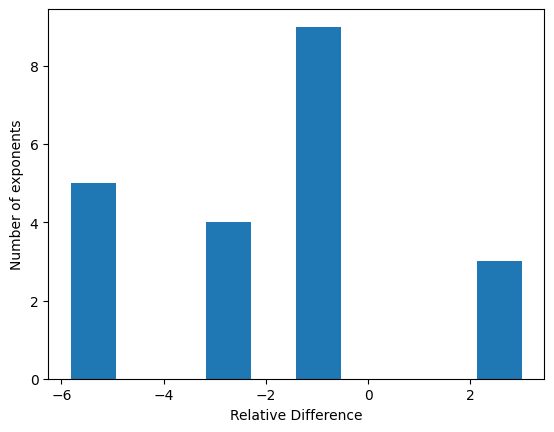

In [1050]:
#calculate A matrix at t0

#earth gravitational constant
mu = 398600.4418*1000**3 #m^3/s^2
AU = 149597870.7*1000 #m

#position and velocity at t0
x = 6990077.798814194 #m
y = 1617465.311978378 #m
z = 22679.810569245355 #m
x_dot = -1675.13972506056 #m/s
y_dot = 7273.72441330686 #m/s
z_dot = 252.688512916741 #m/s

#gravity parameters
J_2 = 0.00108248

#drag parameters
A_Cross = 6 #[m^2]
C_D = 1.88

#third body parameters
mu_sun = 132712440018*1000**3 #[m^3/s^2]
mu_moon = 4902.800066*1000**3 #[m^3/s^2]
JD_UTC = gregorian_to_jd(2018, 2, 1, 5, 0, 0)
leap_sec = 37
del_UT1 = 196.5014 #[s]
r_sun = np.zeros((1, 3))
r_moon = np.zeros((1, 3))
r_sun[0] = sun_position_vector(JD_UTC, leap_sec, del_UT1)
r_moon[0] = moon_position_vector(JD_UTC, leap_sec, del_UT1)


#solar parameters
A_Cross_Sol = 15 #[m^2]



if gravity and drag and solar and third_body:
     A_1 = A(x, y, z, mu, J_2, x_dot, y_dot, z_dot, C_D, A_Cross, A_Cross_Sol, mu_sun, mu_moon, r_sun, r_moon)

elif gravity:
     A_1 = A(x, y, z, mu, J_2)

elif drag:
     A_1 = A(x, y, z, mu, x_dot, y_dot, z_dot, C_D, A_Cross)

elif solar:
     A_1 = A(x, y, z, mu, A_Cross_Sol)

elif third_body:
     A_1 = A(x, y, z, mu, mu_sun, mu_moon, r_sun, r_moon)

else:
     A_1 = A(x, y, z, mu)

A_1 = np.array(A_1)
A_0 = np.array([[0, 0, 0, 1, 0, 0, 0], \
                [0, 0, 0, 0, 1, 0, 0], \
                [0, 0, 0, 0, 0, 1, 0], \
                [1.9938487002181507e-06, 7.110891370508197e-07, 9.970765250251206e-09, 0, 0, 0, 0], \
                [7.110891370508197e-07, -9.146694803540985e-07, 2.3071798898857184e-09, 0, 0, 0, 0], \
                [9.970765250251206e-09, 2.3071798898857184e-09, -1.079179219864052e-06, 0, 0, 0, 0], \
                [0, 0, 0, 0, 0, 0, 0]])

A_true = np.array([[0,0,0,1,0,0,0],
               [0,0,0,0,1,0,0],
               [0,0,0,0,0,1,0],
               [1.9990475733644e-06,7.12612839542376e-07,1.00489067064843e-08,-2.65829597846294e-12,5.52635847842624e-13,2.06452887076393e-14,1.97068091243417e-12],
               [7.12613038229113e-07,-9.15703716126767e-07,2.32534862733938e-09,5.52635847842624e-13,-4.93156219616261e-12,-8.9677255203802e-14,-8.56007671349384e-12],
               [1.00489138810082e-08,2.32534964461914e-09,-1.08334385699352e-06,2.06452887076393e-14,-8.9677255203802e-14,-2.5344195911523e-12,-3.19786086623803e-13],
               [0,0,0,0,0,0,0]])

np.set_printoptions(precision=16)
# print('A_0', A_0[3:6])
print('A_1', A_1[3:6])
# print('residuals', A_1[3:6] - A_0[3:6])
print('A_true', A_true[3:6])
# print('residuals\n', A_true[3:6] - A_1[3:6])

relDiff = np.abs(np.divide((A_1[3:6] - A_true[3:6]), A_true[3:6]))
# print('Relative Difference \n', relDiff)
# print(np.reshape(np.log10(abs(relDiff)), 3*7))
plt.hist(np.reshape(np.log10(relDiff), 3*7))
plt.xlabel('Relative Difference')
plt.ylabel('Number of exponents')

In [879]:
#constants
mu = 398600.4418 #km^3/s^2
# R_earth = 6378.137 #km

e_earth = 0.0818191908426215
omega_earth = 7.2921158553E-5 #rad/s
AU = 149597870.7 #km

#initial conditions
r_0 = np.array([6990077.798814194, 1617465.311978378, 22679.810569245355])#m
v_0 = np.array([-1675.13972506056, 7273.72441330686, 252.688512916741])#m/s

#station locations
stations = np.array([[-6143584, 1364250, 1033743], 
                    [1907295, 6030810, -817119],
                    [2390310, -5564341 , 1994578]]) #m

#time
JD_UTC = gregorian_to_jd(2018, 2, 1, 5, 0, 0)
leap_sec = 37 #s
x_p = 15.361/1000 #arcsec
y_p = 288.259/1000 #arcsec
del_UT1 = 196.5014 #s


In [1051]:
def a_third_body(r, r_sun, r_moon):
    x = r[0]
    y = r[1]
    z = r[2]
    mu_sun = 32712440018*1000**3 #m^3/s^2
    mu_moon = 4902.800066*1000**3 #m^3/s^2
    r_sun_mag = np.linalg.norm(r_sun)
    r_moon_mag = np.linalg.norm(r_moon)
    # del_sun_mag = ((x-r_sun[0])**2 + (y-r_sun[1])**2 + (z-r_sun[2])**2)**(1/2)
    # del_moon_mag = ((x-r_moon[0])**2 + (y-r_moon[1])**2 + (z-r_moon[2])**2)**(1/2)
    # F_x = mu_sun*((x-r_sun[0])/(del_sun_mag)**3 - r_sun[0]/r_sun_mag**3) + mu_moon*((x-r_moon[0])/(del_moon_mag**3) - r_moon[0]/r_moon_mag**3)
    # F_y = mu_sun*((y-r_sun[1])/(del_sun_mag)**3 - r_sun[1]/r_sun_mag**3) + mu_moon*((y-r_moon[1])/(del_moon_mag**3) - r_moon[1]/r_moon_mag**3)
    # F_z = mu_sun*((z-r_sun[2])/(del_sun_mag)**3 - r_sun[2]/r_sun_mag**3) + mu_moon*((z-r_moon[2])/(del_moon_mag**3) - r_moon[2]/r_moon_mag**3)
    del_sun_mag = ((r_sun[0]+x)**2 + (r_sun[1]+y)**2 + (r_sun[2]+z)**2)**(1/2)
    del_moon_mag = ((r_moon[0]+x)**2 + (r_moon[1]+y)**2 + (r_moon[2]+z)**2)**(1/2)
    F_x = mu_sun*((r_sun[0]+x)/(del_sun_mag)**3 - r_sun[0]/r_sun_mag**3) + mu_moon*((r_moon[0]+x)/(del_moon_mag**3) - r_moon[0]/r_moon_mag**3)
    F_y = mu_sun*((r_sun[1]+y)/(del_sun_mag)**3 - r_sun[1]/r_sun_mag**3) + mu_moon*((r_moon[1]+y)/(del_moon_mag**3) - r_moon[1]/r_moon_mag**3)
    F_z = mu_sun*((r_sun[2]+z)/(del_sun_mag)**3 - r_sun[2]/r_sun_mag**3) + mu_moon*((r_moon[2]+z)/(del_moon_mag**3) - r_moon[2]/r_moon_mag**3)

    return np.array([F_x, F_y, F_z])

JD_UTC = gregorian_to_jd(2018, 2, 1, 5, 0, 0)
leap_sec = 37 #s
del_UT1 = 196.5014 #s
r_sun = sun_position_vector(JD_UTC, leap_sec, del_UT1)
print('r_sun', r_sun)
r_moon = moon_position_vector(JD_UTC, leap_sec, del_UT1)
print('r_moon', r_moon)

tb = a_third_body(r_0, r_sun, r_moon)
print('a_third_body', tb)


r_sun [ 9.8687000958363495e+10 -1.0045676260985593e+11 -4.3552029447967728e+10]
r_moon [-2.8230609723236841e+08  2.0707511044040614e+08  9.3972099066557199e+07]
a_third_body [-3.5716045070604124e-07  1.0722276562289009e-06  4.0181787579757628e-07]


In [1052]:
def a_solar(r, s, C_s, C_d, A_Cross_sol):
    
    
    r_ddot = np.zeros(3)
    tau_min = (np.linalg.norm(r)**2 - np.dot(r, s))/(np.linalg.norm(r)**2 + np.linalg.norm(s)**2 - 2*np.dot(r, s))
    
    if tau_min < 0:
        m = 2000 #kg
        c = 299792458 #m/s
        AU = 149597870.7*1000 #m
        d = np.linalg.norm(s+r)/AU #distance from sun
        # print(np.linalg.norm(r))
        # print(d)
        phi = 1367 #W/m^2
        C1 = phi/c 
        v = 1/3*C_d
        mu = 1/2*C_s
        theta = 0
        B = 2*v*np.cos(theta)+4*mu*np.cos(theta)**2
        u = (s+r)/np.linalg.norm(s+r)
        
        r_ddot = (-C1/d**2*(B + (1-mu)*np.cos(theta))*A_Cross_sol/m)*u
    # print(r_ddot)
    return r_ddot

JD_UTC = gregorian_to_jd(2018, 2, 1, 5, 0, 0)
leap_sec = 37
del_UT1 = 196.5014 #[s]
r_sun = sun_position_vector(JD_UTC, leap_sec, del_UT1)
print('r_sun', r_sun)
C_s = 0.04
C_d = 0.04
A_Cross_sol = 15
np.set_printoptions(precision=5, suppress=False)
print(a_solar(r_ECI, r_sun, C_s, C_d, A_Cross_sol))




r_sun [ 9.8687000958363495e+10 -1.0045676260985593e+11 -4.3552029447967728e+10]
[-2.56272e-08  2.60845e-08  1.13089e-08]


In [1054]:
def a_drag(C_D, r, v, A_Cross):

    '''
    Computes the acceleration due to atmospheric drag

    Inputs:
    r - position vector in ECI frame [m]
    v - velocity vector in ECI frame [m/s]
    A_Cross - cross sectional area of satellite [m^2]

    Outputs:
    F_drag - acceleration due to atmospheric drag [m/s^2]
    
    '''

    r_mag = np.linalg.norm(r)
    #drag parameters
    R_earth = 6378.1363*1000 #[m]
    m = 2000 #[kg]
    theta_dot = 7.292115146706979E-5 #[rad/s]
    rho_0 = 3.614E-13 #[kg/m^3]
    H = 88667.0 #[m]
    r0 = (700000.0 + R_earth) #[m]
    rho_A = rho_0*np.exp(-(r_mag-r0)/H)
    
    V_A_bar = np.array([v[0]+theta_dot*r[1], v[1]-theta_dot*r[0], v[2]])
    # print(V_A_bar)
    V_A = np.sqrt((v[0] + theta_dot*r[1])**2 +(v[1]-theta_dot*r[0])**2 + v[2]**2)


    return -1/2*C_D*A_Cross/m*rho_A*V_A*V_A_bar

C_D = 1.88
# print(v_ECI)
print(a_drag(C_D, r_ECI, v_ECI, A_Cross))

[ 3.99307e-09 -1.72934e-08 -6.65623e-10]


In [1055]:
def satellite_motion(t, R, mu, JD_UTC):
    J_2 = 0.00108248

    r = R[0:3]
    r_dot = R[3:6]
    x, y, z = R[0:3]
    JD_UTC += t/86400
    R_earth = 6378.1363*1000 # m
    J_2 = 0.00108248

    #J2
    dUdx = -1.0*mu*x*(-J_2*R_earth**2*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 + y**2 + z**2)**1.0 + 1)/(x**2 + y**2 + z**2)**1.5 \
        + mu*(3.0*J_2*R_earth**2*x*z**2/(x**2 + y**2 + z**2)**3.0 + 2.0*J_2*R_earth**2*x*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 \
        + y**2 + z**2)**2.0)/(x**2 + y**2 + z**2)**0.5
    dUdy = -1.0*mu*y*(-J_2*R_earth**2*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 + y**2 + z**2)**1.0 + 1)/(x**2 + y**2 + z**2)**1.5 \
        + mu*(3.0*J_2*R_earth**2*y*z**2/(x**2 + y**2 + z**2)**3.0 + 2.0*J_2*R_earth**2*y*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 \
        + y**2 + z**2)**2.0)/(x**2 + y**2 + z**2)**0.5
    dUdz = -1.0*mu*z*(-J_2*R_earth**2*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 + y**2 + z**2)**1.0 + 1)/(x**2 + y**2 + z**2)**1.5\
        + mu*(2.0*J_2*R_earth**2*z*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 + y**2 + z**2)**2.0 - J_2*R_earth**2*(-3.0*z**3/(x**2 \
            + y**2 + z**2)**2.0 + 3.0*z/(x**2 + y**2 + z**2)**1.0)/(x**2 + y**2 + z**2)**1.0)/(x**2 + y**2 + z**2)**0.5
    # r_ddot = -mu/np.linalg.norm(r)**3*r
    # #drag
    A_Cross = 6
    C_D = 1.88
    r_ddot_drag = a_drag(C_D, r, r_dot, A_Cross)
    # print('r_ddot_drag', r_ddot_drag)
    # #solar
    leap_sec = 37
    del_UT1 = 196.5014 #[s]
    r_sun = np.zeros((1, 3))
    r_sun[0] = sun_position_vector(JD_UTC, leap_sec, del_UT1)
    C_s = 0.04
    C_d = 0.04
    A_Cross_sol = 15
    r_ddot_sol = a_solar(r, r_sun[0], C_s, C_d, A_Cross_sol)
    # print('r_ddot_sol', r_ddot_sol)

    # #third body
    r_moon = np.zeros((1, 3))
    r_moon[0] = moon_position_vector(JD_UTC, leap_sec, del_UT1)
    r_ddot_tb = a_third_body(r, r_sun[0], r_moon[0])
    # print('r_ddot_tb', r_ddot_tb)


    #total acceleration
    r_ddot = np.array([dUdx, dUdy, dUdz]) + r_ddot_drag  + r_ddot_sol + r_ddot_tb
    # print('r_ddot', r_ddot)
    dydt = np.concatenate((r_dot, r_ddot))
    # print(dydt)
    # print(dydt)
    return dydt


In [1056]:
#initial conditions
t = np.arange(0, 21660, 60)
# r_ECI = np.array([6990077.798814194, 1617465.311978378, 22679.810569245355]) #m
r_ECI = np.array([6984.46459301679,	1612.22237259524,	13.0914313353482])*1000 #m
# v_ECI = np.array([-1675.13972506056, 7273.72441330686, 252.688512916741])#m/s
v_ECI = np.array([-1.67664476668291,	7.26144494619245,	0.259889921085112])*1000 #m/s
mu = 398600.4415*1000**3 #m^3/s^2
JD_UTC = gregorian_to_jd(2018, 2, 1, 5, 0, 0)
#initial Conditions
y0 = np.concatenate([r_ECI, v_ECI])

#numeric integration
sol_sat = solve_ivp(satellite_motion, [0, 21660], y0, args=(mu, JD_UTC), t_eval=t, rtol=3E-14, atol=1E-16)

In [1057]:
np.set_printoptions(precision=16, suppress=True)
print(-5153.82535324096,-4954.3861758395,-144.823727065817,5.17802136652852,-5.38752135424995,-0.211929233793885)
print(sol_sat.y.T[-1]/1000)

-5153.82535324096 -4954.3861758395 -144.823727065817 5.17802136652852 -5.38752135424995 -0.211929233793885
[-5157.1094347076805    -4951.606095633387      -144.79564193549808
     5.174752710490791     -5.390052581269115     -0.2124383357913104]


In [893]:
def light_time_correction(JD_UTC, r_0, v_0, station):
    c = 299792458 #m/s
    ECI_station = ECEF2ECI(station, JD_UTC, leap_sec, x_p, y_p, del_UT1)
    rho_station = np.linalg.norm(r_0 - ECI_station)
    lt = rho_station/c
    tol = 1e-3 #m
    delta = 1
    old_X_lt = np.zeros(6)
    y0 = np.concatenate((r_0, v_0))
    new_X_lt = y0
    while delta > tol:
        old_X_lt = new_X_lt
        t = JD_UTC - lt/86400
        sol = solve_ivp(satellite_motion, [lt, 0], y0, args=(mu, JD_UTC), rtol=3E-14, atol=1E-16)
        new_station = ECEF2ECI(station, t, leap_sec, x_p, y_p, del_UT1)
        new_X_lt = sol.y.T[-1]
        new_rho = np.linalg.norm(new_X_lt[0:3] - new_station)
        lt = new_rho/c
        delta = np.linalg.norm(new_X_lt[0:3] - old_X_lt[0:3])
        
    return new_X_lt, lt

# #test
# r_ECI = np.array([6990077.798814194, 1617465.311978378, 22679.810569245355])#m
# v_ECI = np.array([-1675.13972506056, 7273.72441330686, 252.688512916741])#m/s
# JD_UTC = gregorian_to_jd(2018, 2, 1, 5, 0, 0)   
# c = 299792458 #m/s
# ECIstations = [ECEF2ECI(station, JD_UTC, leap_sec, x_p, y_p, del_UT1) for station in stations]
# station = stations[np.argmin(np.linalg.norm(r_ECI - ECIstations, axis = 1))]
# # r_ECEF = ECI2ECEF(r_ECI, JD_UTC, leap_sec, x_p, y_p, del_UT1)

# X_lt, lt = light_time_correction(JD_UTC, r_ECI, v_ECI, station)

# # print(np.linalg.norm(r_ECI - X_lt[0:3]))
# print(np.array(r_ECI))
# print(X_lt)
# # ax = plt.axes(projection='3d')
# # ax.plot3D(r_ECI[0], r_ECI[1], r_ECI[2], 'o', color = 'red')
# # ax.plot3D(X_lt[0], X_lt[1], X_lt[2], 'o')
# # ax.plot3D(0, 0, 0, 'o')


In [894]:
#H_tilde
def rho(station):
    x = sym.Symbol('x')
    y = sym.Symbol('y')
    z = sym.Symbol('z')
    x_dot = sym.Symbol('x_dot')
    y_dot = sym.Symbol('y_dot')
    z_dot = sym.Symbol('z_dot')

    x_s = station[0]
    y_s = station[1]
    z_s = station[2]
    
    rho = sym.sqrt((x - x_s)**2 + (y - y_s)**2 + (z - z_s)**2)
    #for project omega x r ECEF frame
    #vallado chapter 4 ECEF to ECI transformation
    omega_earth = np.array([0, 0, 7.292115146706979E-5]) #rad/s
    station_dot = np.cross(station, omega_earth)
    rho_dot = ((x-x_s)*(x_dot-station_dot[0]) + (y-y_s)*(y_dot-station_dot[1]) + (z-z_s)*(z_dot-station_dot[2]))/rho
    return rho, rho_dot

ECIstations = [ECEF2ECI(station, JD_UTC, leap_sec, x_p, y_p, del_UT1) for station in stations]
station = stations[np.argmin(np.linalg.norm(r_0 - ECIstations, axis = 1))]
ECIstation = ECIstations[np.argmin(np.linalg.norm(r_0 - ECIstations, axis = 1))]
rho_1, drho_1 = rho(ECIstation)


x = sym.Symbol('x')
y = sym.Symbol('y')
z = sym.Symbol('z')
x_dot = sym.Symbol('x_dot')
y_dot = sym.Symbol('y_dot')
z_dot = sym.Symbol('z_dot')
C_D = sym.Symbol('C_D')

H_tilde_sym = [[sym.diff(rho_1, x), sym.diff(rho_1, y), sym.diff(rho_1, z), sym.diff(rho_1, x_dot), sym.diff(rho_1, y_dot), sym.diff(rho_1, z_dot), sym.diff(rho_1, C_D)],[
           sym.diff(drho_1, x), sym.diff(drho_1, y), sym.diff(drho_1, z), sym.diff(drho_1, x_dot), sym.diff(drho_1, y_dot), sym.diff(drho_1, z_dot), sym.diff(drho_1, C_D)]]
r_ECI = np.array([6990077.798814194, 1617465.311978378, 22679.810569245355]) #km
# r_ECI = np.array([6984.46459301679,	1612.22237259524,	13.0914313353482])*1000 #m
v_ECI = np.array([-1675.13972506056, 7273.72441330686, 252.688512916741])#km/s
# v_ECI = np.array([-1.67664476668291,	7.26144494619245,	0.259889921085112])*1000 #m/s


r_lt, lt = light_time_correction(JD_UTC, r_ECI, v_ECI, station)
H_tilde_func = sym.lambdify((x, y, z, x_dot, y_dot, z_dot, C_D), H_tilde_sym, 'numpy')
H_tilde = H_tilde_func(r_lt[0], r_lt[1], r_lt[2], r_lt[3], r_lt[4], r_lt[5], 1.88)

H_tilde_true = np.array([[0.653470716486393,0.102498573784402,-0.749980043112431,0,0,0,0],
[-0.000923151547374937,0.00515759358602085,-9.94780021776166e-05,0.653470716486393,0.102498573784402,-0.749980043112431,0]])

# print(np.array(H_tilde))
# # print(np.array(H_tilde_lt))
# print(H_tilde_true)
reldiff = np.divide(np.abs(H_tilde - H_tilde_true), H_tilde_true)
print(reldiff)

6096679.86431283*sqrt((1.64023701794405e-7*x - 1)**2 + 0.0661621108153975*(6.37678732569624e-7*y - 1)**2 + 0.028106607990635*(9.78368340843248e-7*z - 1)**2)
[[ 0.0191807643  0.6418434526 -0.0065821011           nan           nan
            nan           nan]
 [-0.1447942389  0.1214071586 -3.229556204   0.0191807643  0.6418434526
  -0.0065821011           nan]]


In [550]:
def load_egm96_coefficients():

    EGM96_C_file = 'EGM96_C.csv'
    EGM96_S_file = 'EGM96_S.csv'

    # Load EGM96 coefficients from file
    C = []
    S = []
    # Read in the CSV file and populate the matrix
    with open(EGM96_C_file, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            C.append(row)
    # S = np.loadtxt(EGM96_S_file)
    with open(EGM96_S_file, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            S.append(row)
    C = np.array(C).astype(float)
    S = np.array(S).astype(float)
    return C, S

In [551]:
def loc_gravLegendre(phi, maxdeg):

    '''
    This function computes the fully normalized associated Legendre functions
    and their derivatives up to degree and order maxdeg at latitude phi.

    input:
        phi: latitude [rad]
        maxdeg: maximum degree and order of the spherical harmonic expansion

    output:
        P: fully normalized associated Legendre functions
        scaleFactor: scaling factor for the fully normalized associated Legendre functions
        
    '''
    # Initialize arrays
    P = np.zeros((maxdeg+3, maxdeg+3, 1))
    scaleFactor = np.zeros((maxdeg+3, maxdeg+3, 1))
    cphi = np.cos(np.pi/2-phi)
    sphi = np.sin(np.pi/2-phi)

    # Force numerically zero values to be exactly zero
    if np.abs(cphi) <= np.finfo(float).eps:
        cphi = 0
    if np.abs(sphi) <= np.finfo(float).eps:
        sphi = 0

    # Seeds for recursion formula
    P[0,0,:] = 1     # n = 0, m = 0;
    P[1,0,:] = np.sqrt(3)*cphi   # n = 1, m = 0;
    scaleFactor[0,0,:] = 0
    scaleFactor[1,0,:] = 1
    P[1,1,:] = np.sqrt(3)*sphi   # n = 1, m = 1;
    scaleFactor[1,1,:] = 0

    for n in range(2, maxdeg+3):
        k = n + 1
        for m in range(0, n+1):
            p = m + 1
            # Compute normalized associated legendre polynomials, P, via recursion relations 
            # Scale Factor needed for normalization of dUdphi partial derivative
            if n == m:
                P[k-1,k-1,:] = np.sqrt(2*n+1)/np.sqrt(2*n)*sphi*P[k-2,k-2,:]
                scaleFactor[k-1,k-1,:] = 0
            elif m == 0:
                P[k-1,p,:] = (np.sqrt(2*n+1)/n)*(np.sqrt(2*n-1)*cphi*P[k-2,p,:] - (n-1)/np.sqrt(2*n-3)*P[k-3,p,:])
                scaleFactor[k-1,p,:] = np.sqrt((n+1)*n/2)
            else:
                P[k-1,p,:] = np.sqrt(2*n+1)/(np.sqrt(n+m)*np.sqrt(n-m))*(np.sqrt(2*n-1)*cphi*P[k-2,p,:] - np.sqrt(n+m-1)*np.sqrt(n-m-1)/np.sqrt(2*n-3)*P[k-3,p,:])
                scaleFactor[k-1,p,:] = np.sqrt((n+m+1)*(n-m))

    return P, scaleFactor


In [552]:
def loc_gravityPCPF(p, maxdeg, P, C, S, smlambda, cmlambda, GM, Re, r, scaleFactor):
    '''
    Computes the gravity acceleration in the ECEF frame

    input:
        p: position vector in ECEF frame [m]
        maxdeg: maximum degree and order of the spherical harmonic expansion
        P: fully normalized associated Legendre functions
        C: cosine spherical harmonic coefficients
        S: sine spherical harmonic coefficients
        smlambda: sine of the product of the longitude and degree
        cmlambda: cosine of the product of the longitude and degree
        GM: gravitational constant times the mass of the Earth [m^3/s^2]
        Re: mean radius of the Earth [m]
        r: magnitude of the position vector [m]
        scaleFactor: scaling factor for the fully normalized associated Legendre functions

    output:
        gx: x gravity acceleration in the ECEF frame [m/s^2]
        gy: y gravity acceleration in the ECEF frame [m/s^2]
        gz: z gravity acceleration in the ECEF frame [m/s^2]
    '''
    
    rRatio   = Re/r
    rRatio_n = rRatio.copy()
    
    # initialize summation of gravity in radial coordinates
    dUdrSumN      = 1
    dUdphiSumN    = 0
    dUdlambdaSumN = 0
    # summation of gravity in radial coordinates
    for n in range(2, maxdeg+1):
        k = n+1
        rRatio_n      = rRatio_n*rRatio
        dUdrSumM      = 0
        dUdphiSumM    = 0
        dUdlambdaSumM = 0
        for m in range(n+1):
            j = m
            dUdrSumM      = dUdrSumM + P[k-1,j]*(C[k-1,j]*cmlambda[:,j] + S[k-1,j]*smlambda[:,j])
            dUdphiSumM    = dUdphiSumM + ((P[k-1,j+1]*scaleFactor[k-1,j,:] - p[2]/np.sqrt(p[0]**2 + p[1]**2)*m*P[k-1,j])*(C[k-1,j]*cmlambda[:,j] + S[k-1,j]*smlambda[:,j]))
            dUdlambdaSumM = dUdlambdaSumM + m*P[k-1,j]*(S[k-1,j]*cmlambda[:,j] - C[k-1,j]*smlambda[:,j])
        dUdrSumN      = dUdrSumN      + dUdrSumM*rRatio_n*k
        dUdphiSumN    = dUdphiSumN    + dUdphiSumM*rRatio_n
        dUdlambdaSumN = dUdlambdaSumN + dUdlambdaSumM*rRatio_n
    
    # gravity in spherical coordinates
    dUdr      = -GM/(r**2)*dUdrSumN
    dUdphi    =  GM/r*dUdphiSumN
    dUdlambda =  GM/r*dUdlambdaSumN
    
    # gravity in ECEF coordinates
    gx = ((1/r)*dUdr - (p[2]/(r**2*np.sqrt(p[0]**2 + p[1]**2)))*dUdphi)*p[0] \
          - (dUdlambda/(p[0]**2 + p[1]**2))*p[1]
    gy = ((1/r)*dUdr - (p[2]/(r**2*np.sqrt(p[0]**2 + p[1]**2)))*dUdphi)*p[1] \
          + (dUdlambda/(p[0]**2 + p[1]**2))*p[0]
    gz = (1.0/r)*dUdr*p[2] + ((np.sqrt(p[0]*p[0] + p[1]*p[1]))/(r*r))*dUdphi

    # special case for poles
    atPole = np.abs(np.arctan2(p[2], np.sqrt(p[0]*p[0] + p[1]*p[1]))) == np.pi/2
    if np.any(atPole):
        gx[atPole] = 0
        gy[atPole] = 0
        gz[atPole] = (1.0/r[atPole])*dUdr[atPole]*p[atPole,2]
    # print(gx, gy, gz)
    return gx[0], gy[0], gz[0]

In [609]:
def F_gravity_vallado(p, C, S):
    ''' 
    # F_GRAVITY_VALLADO computes the acceleration due to gravity in the
    # Earth-Centered Inertial (ECI) frame using the Vallado algorithm.

    # Inputs:
    #   p_ECI - Nx3 array of ECI positions [m]

    # Outputs:
    #   g_ECI - Nx3 array of ECI accelerations [m/s^2]'''
   

    
    maxdeg = 2
    mu = 3.986004418e14 # m^3/s^2
    Re = 6378.145*1000 #[m] # m
    r = np.linalg.norm(p)
    
    # Compute geocentric latitude
    phic = np.arcsin(p[2] / r)

    # Compute lambda
    lambda_ = np.arctan2(p[1], p[0])

    smlambda = np.zeros((p.shape[0], maxdeg+1))
    cmlambda = np.zeros((p.shape[0], maxdeg+1))

    slambda = np.sin(lambda_)
    clambda = np.cos(lambda_)
    smlambda[:,0] = 0
    cmlambda[:,0] = 1
    smlambda[:,1] = slambda
    cmlambda[:,1] = clambda

    for m in range(2, maxdeg+1):
        smlambda[:,m] = 2.0 * clambda * smlambda[:, m-1] - smlambda[:, m-2]
        cmlambda[:,m] = 2.0 * clambda * cmlambda[:, m-1] - cmlambda[:, m-2]

    # compute normalized legendre polynomials
    P, scaleFactor = loc_gravLegendre(phic, maxdeg)
    # print(P.shape)

    # Compute gravity in ECEF coordinates
    gx, gy, gz = loc_gravityPCPF(p, maxdeg, P, C[0:maxdeg+1, 0:maxdeg+1],
                                S[0:maxdeg+1, 0:maxdeg+1], smlambda,
                                cmlambda, mu, Re, r, scaleFactor)
    
    g_ECEF = np.array([gx, gy, gz])
    return g_ECEF


In [1058]:
#constants

#initial conditions
r_ECI = np.array([6990077.798814194, 1617465.311978378, 22679.810569245355])#m
v_ECI = np.array([-1675.13972506056, 7273.72441330686, 252.688512916741])#m/s
JD_UTC = gregorian_to_jd(2018, 2, 1, 5, 0, 0)
leap_sec = 37 #s
x_p = 15.361/1000 #arcsec
y_p = 288.259/1000 #arcsec
del_UT1 = 196.5014 #s
C, S = load_egm96_coefficients()
r_ECEF = ECI2ECEF(r_ECI, JD_UTC, leap_sec, x_p, y_p, del_UT1)
g_ECEF = F_gravity_vallado(r_ECEF, C, S)
g_ECI = ECEF2ECI(g_ECEF, JD_UTC, leap_sec, x_p, y_p, del_UT1)
# drag_force = F_drag(r_0, v_0, 6/1000**2)
print("g_force", g_ECI)
# print("drag_force", drag_force)
# print((1.9938487002181507e-06 + -mu/np.linalg.norm(r_0)**3 + g_force[0]) - 1.9990475733644e-06)
# print((1.9938487002181507e-06 + g_force[0]))

g_force [-7.5438696526434725 -1.7456120896854026 -0.0244769554169401]


In [559]:
#EGM96 Dynamics
t = np.arange(0, 2100, 60)

#initial conditions
r_0 = np.array([6990077.798814194, 1617465.311978378, 22679.810569245355]) #km
# r_0 = np.array([6984.46459301679,	1612.22237259524,	13.0914313353482])*1000 #m
v_0 = np.array([-1675.13972506056, 7273.72441330686, 252.688512916741])#km/s
# v_0 = np.array([-1.67664476668291,	7.26144494619245,	0.259889921085112])*1000 #m/s
# r_ECEF = ECI2ECEF(r_ECI, JD_UTC, leap_sec, x_p, y_p, del_UT1)
C, S = load_egm96_coefficients()
mu = 398600.4415*1000**3 #m^3/s^2
JD_UTC = gregorian_to_jd(2018, 2, 1, 5, 0, 0)

def satellite_motion_EGM96(t, y, C, S, JD_UTC):
    r_ECI = y[0:3]
    r_dot = y[3:6]
    JD_UTC += t/86400
    leap_sec = 37 #s
    x_p = 15.361/1000 #arcsec
    y_p = 288.259/1000 #arcsec
    del_UT1 = 196.5014 #s
    # r_ECEF = ECI2ECEF(r_ECI, JD_UTC, leap_sec, x_p, y_p, del_UT1)
    g_ECEF = F_gravity_vallado(r_ECI, C, S)
    g_ECI = ECEF2ECI(g_ECEF, JD_UTC, leap_sec, x_p, y_p, del_UT1)
    r_ddot = g_ECI
    # + F_drag(r, r_dot, 6/(1000**2))
    # print(r_ddot)
    return np.concatenate([r_dot, r_ddot])

#initial Conditions
y0 = np.concatenate([r_0, v_0])

#numeric integration
# sol_EGM = solve_ivp(satellite_motion_EGM96, [0, 2100], y0, args=(C, S, JD_UTC), t_eval=t, rtol=3E-14, atol=1E-16)


In [560]:
# print(sol_EGM.y[0][-1]/1000, sol_EGM.y[1][-1]/1000, sol_EGM.y[2][-1]/1000)   

In [561]:
# print(sol_EGM.y[0][-1]/1000, sol_EGM.y[1][-1]/1000, sol_EGM.y[2][-1]/1000)   

In [1059]:
def satellite_motion_phi(t, R, mu, A, JD_UTC):
    J_2 = 0.00108248
    phi = R[6:].reshape(7, 7)
    R_earth = 6378.1363*1000 # m
    r = R[0:3]
    r_dot = R[3:6]
    x, y, z = R[0:3]
    x_dot, y_dot, z_dot = R[3:6]
    JD_UTC += t/86400

    #J2
    dUdx = -1.0*mu*x*(-J_2*R_earth**2*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 + y**2 + z**2)**1.0 + 1)/(x**2 + y**2 + z**2)**1.5 \
        + mu*(3.0*J_2*R_earth**2*x*z**2/(x**2 + y**2 + z**2)**3.0 + 2.0*J_2*R_earth**2*x*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 \
        + y**2 + z**2)**2.0)/(x**2 + y**2 + z**2)**0.5
    dUdy = -1.0*mu*y*(-J_2*R_earth**2*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 + y**2 + z**2)**1.0 + 1)/(x**2 + y**2 + z**2)**1.5 \
        + mu*(3.0*J_2*R_earth**2*y*z**2/(x**2 + y**2 + z**2)**3.0 + 2.0*J_2*R_earth**2*y*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 \
        + y**2 + z**2)**2.0)/(x**2 + y**2 + z**2)**0.5
    dUdz = -1.0*mu*z*(-J_2*R_earth**2*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 + y**2 + z**2)**1.0 + 1)/(x**2 + y**2 + z**2)**1.5\
        + mu*(2.0*J_2*R_earth**2*z*(1.5*z**2/(x**2 + y**2 + z**2)**1.0 - 0.5)/(x**2 + y**2 + z**2)**2.0 - J_2*R_earth**2*(-3.0*z**3/(x**2 \
            + y**2 + z**2)**2.0 + 3.0*z/(x**2 + y**2 + z**2)**1.0)/(x**2 + y**2 + z**2)**1.0)/(x**2 + y**2 + z**2)**0.5
    
    #drag
    A_Cross = 6
    C_D = 1.88
    r_ddot_drag = a_drag(C_D, r, r_dot, A_Cross)

    #solar
    leap_sec = 37
    del_UT1 = 196.5014 #[s]
    r_sun = np.zeros((1, 3))
    r_sun[0] = sun_position_vector(JD_UTC, leap_sec, del_UT1)
    C_s = 0.04
    C_d = 0.04
    A_Cross_sol = 15
    r_ddot_sol = a_solar(r, r_sun[0], C_s, C_d, A_Cross_sol)
    

    #third body
    r_moon = np.zeros((1, 3))
    r_moon[0] = moon_position_vector(JD_UTC, leap_sec, del_UT1)
    r_ddot_tb = a_third_body(r, r_sun[0], r_moon[0])


    #total acceleration
    r_ddot = np.array([dUdx, dUdy, dUdz]) + r_ddot_drag  + r_ddot_sol + r_ddot_tb
    
    #A matrix
    A_1 = np.array(A(x, y, z, mu, J_2, x_dot, y_dot, z_dot, C_D, A_Cross, A_Cross_Sol, mu_sun, mu_moon, r_sun, r_moon))
    
    #state transition matrix
    phi_dot = np.matmul(A_1, phi)
   
    dydt = np.concatenate((r_dot, r_ddot, phi_dot.ravel()))
    # print(dydt)
    return dydt





In [1060]:

#initial conditions
t = np.arange(0, 21660, 60)
r_ECI = np.array([6990077.798814194, 1617465.311978378, 22679.810569245355]) #m
# r_ECI = np.array([6984.46459301679,	1612.22237259524,	13.0914313353482])*1000 #m
v_ECI = np.array([-1675.13972506056, 7273.72441330686, 252.688512916741])#m/s
# v_ECI = np.array([-1.67664476668291,	7.26144494619245,	0.259889921085112])*1000 #m/s
mu = 398600.4415*1000**3 #m^3/s^2
JD_UTC = gregorian_to_jd(2018, 2, 1, 5, 0, 0)
phi = np.eye(7)
#initial Conditions
y0 = np.concatenate([r_ECI, v_ECI, phi.ravel()])

#numeric integration
sol_J2 = solve_ivp(satellite_motion_phi, [0, 21660], y0, args=(mu, A, JD_UTC), t_eval=t, rtol=3E-14, atol=1E-16)

In [564]:
print([-5153.82535324096, -4954.3861758395, -144.823727065817])

[-5153.82535324096, -4954.3861758395, -144.823727065817]


In [1061]:
print(sol_J2.y.T[-1][0]/1000, sol_J2.y.T[-1][1]/1000, sol_J2.y.T[-1][2]/1000)
print(sol_J2.y.T[-1][3]/1000, sol_J2.y.T[-1][4]/1000, sol_J2.y.T[-1][5]/1000)

-5981.722030141619 -4023.514013614197 -114.43087472519876
4.161283868591955 -6.153812367493416 -0.2229784330929654


phi_true [[   -39.3391    -10.4838     -0.1785   7255.5175 -39670.7241  -1372.292
       0.003 ]
 [    52.8127     14.8761      0.2936  -8643.5976  52182.3557   1811.8195
      -0.0039]
 [     1.924       0.5722     -0.9169   -320.2231   1920.5425   -303.7856
      -0.0001]
 [    -0.0574     -0.0148     -0.0002     10.8033    -56.9191     -1.9722
       0.    ]
 [    -0.0362     -0.0098     -0.0002      6.0995    -35.0199     -1.1778
       0.    ]
 [    -0.001      -0.0003      0.0004      0.1638     -0.952      -0.9511
       0.    ]
 [     0.          0.          0.          0.          0.          0.
       1.    ]]
phi [[   -39.3068    -10.4758     -0.178    7248.708  -39637.2613  -1371.9408
       3.0403]
 [    52.8236     14.8794      0.2931  -8644.4336  52190.9165   1813.2771
      -3.914 ]
 [     1.926       0.5727     -0.9171   -320.5982   1922.397    -303.199
      -0.1434]
 [    -0.0574     -0.0148     -0.0002     10.8026    -56.9229     -1.9735
       0.0043]
 [    -0.0362

Text(0, 0.5, 'Number of exponents')

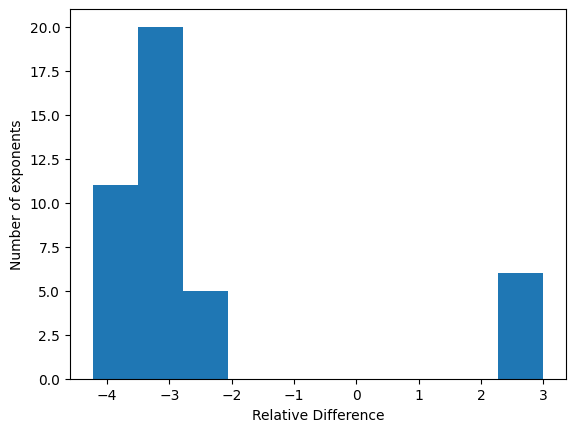

In [1062]:
np.set_printoptions(precision=4, suppress=True)
phi_true = np.array([-39.3390954700328,-10.4838421164098,-0.178515806381632,7255.51749588224,-39670.7241027289,-1372.29198687773,0.0030445773158455,
52.8126590572353,14.8760562610219,0.293617329755136,-8643.59756483467,52182.3557002297,1811.8195497131,-0.00391612715718706,
1.92398345007054,0.572231449979784,-0.916857134048049,-320.223120784111,1920.54246971582,-303.785573374237,-0.000143323034520295,
-0.0574389810576982,-0.0148097800062921,-0.00023756274651235,10.8032803603046,-56.9190551092895,-1.9721591633074,4.34741301050209e-06,
-0.0361975224561024,-0.0098256188572871,-0.000180772521863657,6.09947887593858,-35.0199347490215,-1.17782026574266,2.70486338281634e-06,
-0.00101917635090016,-0.000293484527003083,0.000395824353451442,0.163846785698186,-0.952008640270825,-0.951074388701294,7.62686157098573e-08,
0,0,0,0,0,0,1]).reshape(7,7)
print('phi_true', phi_true)
phi = sol_J2.y.T[-1][6:].reshape(7,7)
print('phi', phi)
relDiffPhi = abs(np.divide((phi[:6] - phi_true[:6]), phi_true[:6]))
# print('residuals', phi-phi_true)
# print(relDiffPhi)
plt.hist(np.reshape(np.log10(abs(relDiffPhi)), relDiffPhi.shape[0]*relDiffPhi.shape[1]))
plt.xlabel('Relative Difference')
plt.ylabel('Number of exponents')

In [1065]:
def range_range_rate(r, v, station, station_dot):
    x = r[0]
    y = r[1]
    z = r[2]
    x_dot = v[0]
    y_dot = v[1]
    z_dot = v[2]

    x_s = station[0]
    y_s = station[1]
    z_s = station[2]
    x_s_dot = station_dot[0]
    y_s_dot = station_dot[1]
    z_s_dot = station_dot[2]
    
    rho = np.sqrt((x - x_s)**2 + (y - y_s)**2 + (z - z_s)**2)
    omega_earth = np.array([0, 0, 7.292115146706979E-5]) #rad/s
    rho_dot = ((x-x_s)*(x_dot-x_s_dot) + (y-y_s)*(y_dot-y_s_dot) + (z-z_s)*(z_dot-z_s_dot))/rho
    return rho, rho_dot


In [1066]:
with open('range_rate.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for i in range(0, len(sol_J2.y.T)):
        r_ECI = sol_J2.y.T[i][0:3]
        v_ECI = sol_J2.y.T[i][3:6]
        JD_UTC_i = JD_UTC + i*60/86400
        ECIstations = [ECEF2ECI(station, JD_UTC_i, leap_sec, x_p, y_p, del_UT1) for station in stations]
        station_index = np.argmin(np.linalg.norm(r_ECI - ECIstations, axis = 1))
        station = stations[station_index]
        station_dot = np.cross(station, omega_earth+i*60*omega_earth)
        ECIstation_dot = ECEF2ECI(station_dot, JD_UTC_i, leap_sec, x_p, y_p, del_UT1)
        ECIstation = ECIstations[station_index]
        r_lt, lt = light_time_correction(JD_UTC_i, r_ECI, v_ECI, station)
        rho, rho_dot = range_range_rate(r_lt[0:3], r_lt[3:6], ECIstation, ECIstation_dot)
        writer.writerow([station_index+1, i*60, rho/1000, rho_dot/1000])
        # print(station_index+1, rho/1000, rho_dot/1000)
# print(sol_J2.y.T[0][0]/1000, sol_J2.y.T[0][1]/1000, sol_J2.y.T[0][2]/1000)
# ECIstations = [ECEF2ECI(station, JD_UTC, leap_sec, x_p, y_p, del_UT1) for station in stations]
# r_lt, lt = light_time_correction(JD_UTC, r_ECI, v_ECI, station)
# print(r_lt)
# rho, rho_dot = range_range_rate(r_lt[0:3], r_lt[3:6], ECIstation)
# # rho, rho_dot = range_range_rate(r_ECI, v_ECI, ECIstation)
# print(rho/1000, rho_dot/1000)

AxisError: axisb: axis -1 is out of bounds for array of dimension 0